In [6]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from CNN2D import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [61]:
gt_train_coord = pickle.load( open( "./import_dataset_3/train/gt_train_coord.pkl", "rb" ) )
gt_train  = pickle.load( open( "./import_dataset_3/train/gt_train.pkl", "rb" ) )
in_train_coord  = pickle.load( open( "./import_dataset_3/train/in_train_coord.pkl", "rb" ) )
inputs_train = pickle.load( open( "./import_dataset_3/train/inputs_train.pkl", "rb" ) )

inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()

gt_train = gt_train.unsqueeze(1) # add 1 dimension to the training set
inputs_train = inputs_train.unsqueeze(1) # add 1 dimension to the training set

inputs_train.shape,gt_train.shape

(torch.Size([5157, 1, 10, 244]), torch.Size([5157, 1, 11, 4]))

## VALIDATION SET

In [62]:
gt_validation_coord = pickle.load( open( "./import_dataset_3/validation/gt_validation_coord.pkl", "rb" ) )
gt_validation = pickle.load( open( "./import_dataset_3/validation/gt_validation.pkl", "rb" ) )
in_validation_coord = pickle.load( open( "./import_dataset_3/validation/in_validation_coord.pkl", "rb" ) )
inputs_validation = pickle.load( open( "./import_dataset_3/validation/inputs_validation.pkl", "rb" ) )

inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()

gt_validation = gt_validation.unsqueeze(1) # add 1 dimension to the training set
inputs_validation = inputs_validation.unsqueeze(1) # add 1 dimension to the training set
print (inputs_validation.shape)

gt_validation_coord.shape,gt_validation.shape,in_validation_coord.shape,inputs_validation.shape

torch.Size([1719, 1, 10, 244])


((11, 1719, 2),
 torch.Size([1719, 1, 11, 4]),
 (10, 1719, 2),
 torch.Size([1719, 1, 10, 244]))

## TEST SET

In [63]:
gt_test_coord_1 = pickle.load( open( "./import_dataset_3/test/gt_test_coord_1.pkl", "rb" ) )
gt_test_1 = pickle.load( open( "./import_dataset_3/test/gt_test_1.pkl", "rb" ) )
in_test_coord_1 = pickle.load( open( "./import_dataset_3/test/in_test_coord_1.pkl", "rb" ) )
inputs_test_1 = pickle.load( open( "./import_dataset_3/test/inputs_test_1.pkl", "rb" ) )

gt_test_coord_2 = pickle.load( open( "./import_dataset_3/test/gt_test_coord_2.pkl", "rb" ) )
gt_test_2 = pickle.load( open( "./import_dataset_3/test/gt_test_2.pkl", "rb" ) )
in_test_coord_2 = pickle.load( open( "./import_dataset_3/test/in_test_coord_2.pkl", "rb" ) )
inputs_test_2 = pickle.load( open( "./import_dataset_3/test/inputs_test_2.pkl", "rb" ) )

gt_test_coord_3 = pickle.load( open( "./import_dataset_3/test/gt_test_coord_3.pkl", "rb" ) )
gt_test_3 = pickle.load( open( "./import_dataset_3/test/gt_test_3.pkl", "rb" ) )
in_test_coord_3 = pickle.load( open( "./import_dataset_3/test/in_test_coord_3.pkl", "rb" ) )
inputs_test_3 = pickle.load( open( "./import_dataset_3/test/inputs_test_3.pkl", "rb" ) )

inputs_test_1 = torch.from_numpy(inputs_test_1).float()
gt_test_1 = torch.from_numpy(gt_test_1).float()
inputs_test_1 = inputs_test_1.unsqueeze(1) 

inputs_test_2 = torch.from_numpy(inputs_test_2).float()
gt_test_2 = torch.from_numpy(gt_test_2).float()
inputs_test_2 = inputs_test_2.unsqueeze(1)

inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()
inputs_test_3 = inputs_test_3.unsqueeze(1)
print (inputs_test_3.shape)

torch.Size([10, 1, 460, 244])


### Model

In [64]:
net = CNN2D()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)

traindataset = utils.TensorDataset(inputs_train, gt_train[:,:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

In [65]:
epochs = 150
steps = 0
running_loss = 0
print_every = 323
loss_train = []
loss_val = []

for e in range(epochs):
    start = time.time()
    steps_bis = 0
    total_train_loss=0
    for train_coord, ground_tru in iter(trainloader):
        
        steps += 1
        steps_bis += 1
        
        input_train = Variable(train_coord)
        in_train = input_train.squeeze(1)
        target = Variable(ground_tru)
        targets = target.squeeze(1)
        optimizer.zero_grad()
        out = net.forward(input_train)
        out = out.reshape(out.shape[0],10,4)
        out_bis = out[:,:,0:2].clone()  
        for i in range(10):
            if i == 0:
                out_bis[:, i, 0:2] = in_train[:, -1, 0:2] + out[:, i, 2:]*0.4
            else:
                out_bis[:, i, 0:2] = out[:, i - 1, 0:2] + out[:, i, 2:]*0.4
        
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
        
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3).item()
        total_train_loss += (loss1+loss2+loss3).item()
        
        if steps % print_every == 0:
            stop = time.time()
            val_loss=0
            
            for ii, (images, labels) in enumerate(valloader):
                
                inp = Variable(images)
                input_val = inp.squeeze(1)
                lab = Variable(labels)
                valgt = lab.squeeze(1)
                predicted = net.predict(inp)
                predicted = predicted.reshape(predicted.shape[0],10,4)
                predicted_bis = predicted[:,:,0:2].clone()
                #print(out_bis.shape)   
                for i in range(10):
                    if i == 0:
                        predicted_bis[:, i, 0:2] = input_val[:, -1, 0:2] + predicted[:, i, 2:]*0.4
                    else:
                        predicted_bis[:, i, 0:2] = predicted[:, i - 1, 0:2] + predicted[:, i, 2:]*0.4
                val_loss+= (criterion(predicted[:,:,0:2],valgt[:,:,0:2]).item()
                                + criterion(predicted[:,:,2:],valgt[:,:,2:]).item()
                                + criterion(predicted_bis, valgt[:,:,0:2]).item())
                
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation Loss: {:.4f}..".format(val_loss/ii),
                  "Training Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                 )
            loss_val.append(val_loss/ii)
            running_loss = 0
            start = time.time()
    loss_train.append(total_train_loss/steps_bis)

Epoch: 1/150.. Validation Loss: 5.3286.. Training Loss: 7.7854.. 0.0275 s/batch 
Epoch: 2/150.. Validation Loss: 3.8859.. Training Loss: 4.5558.. 0.0307 s/batch 
Epoch: 3/150.. Validation Loss: 2.8122.. Training Loss: 3.2166.. 0.0278 s/batch 
Epoch: 4/150.. Validation Loss: 2.3157.. Training Loss: 2.5116.. 0.0282 s/batch 
Epoch: 5/150.. Validation Loss: 2.1535.. Training Loss: 2.1510.. 0.0271 s/batch 
Epoch: 6/150.. Validation Loss: 1.9802.. Training Loss: 1.9519.. 0.0295 s/batch 
Epoch: 7/150.. Validation Loss: 1.8451.. Training Loss: 1.8232.. 0.0266 s/batch 
Epoch: 8/150.. Validation Loss: 1.7614.. Training Loss: 1.7099.. 0.0291 s/batch 
Epoch: 9/150.. Validation Loss: 1.6803.. Training Loss: 1.6105.. 0.0351 s/batch 
Epoch: 10/150.. Validation Loss: 1.5687.. Training Loss: 1.5157.. 0.0385 s/batch 
Epoch: 11/150.. Validation Loss: 1.4827.. Training Loss: 1.4171.. 0.0348 s/batch 
Epoch: 12/150.. Validation Loss: 1.3945.. Training Loss: 1.3043.. 0.0393 s/batch 
Epoch: 13/150.. Validatio

Epoch: 102/150.. Validation Loss: 0.7286.. Training Loss: 0.3874.. 0.0423 s/batch 
Epoch: 103/150.. Validation Loss: 0.7332.. Training Loss: 0.3878.. 0.0420 s/batch 
Epoch: 104/150.. Validation Loss: 0.7466.. Training Loss: 0.3910.. 0.0461 s/batch 
Epoch: 105/150.. Validation Loss: 0.7424.. Training Loss: 0.3858.. 0.0379 s/batch 
Epoch: 106/150.. Validation Loss: 0.7252.. Training Loss: 0.3851.. 0.0420 s/batch 
Epoch: 107/150.. Validation Loss: 0.8326.. Training Loss: 0.3854.. 0.0381 s/batch 
Epoch: 108/150.. Validation Loss: 0.7447.. Training Loss: 0.3816.. 0.0438 s/batch 
Epoch: 109/150.. Validation Loss: 0.7559.. Training Loss: 0.3801.. 0.0393 s/batch 
Epoch: 110/150.. Validation Loss: 0.7351.. Training Loss: 0.3731.. 0.0428 s/batch 
Epoch: 111/150.. Validation Loss: 0.7178.. Training Loss: 0.3707.. 0.0399 s/batch 
Epoch: 112/150.. Validation Loss: 0.7736.. Training Loss: 0.3823.. 0.0440 s/batch 
Epoch: 113/150.. Validation Loss: 0.7552.. Training Loss: 0.3727.. 0.0379 s/batch 
Epoc

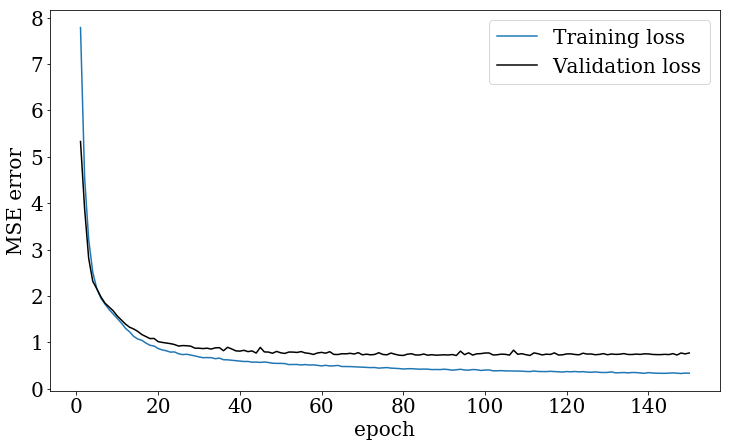

In [66]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()

In [67]:
output_test_1 = net.predict(inputs_test_1)
output_test_1 = output_test_1.data.numpy()
output_test_1 = np.reshape(output_test_1,(250,10,4))

output_test_2 = net.predict(inputs_test_2)
output_test_2 = output_test_2.data.numpy()
output_test_2 = np.reshape(output_test_2,(1006,10,4))

output_test_3 = net.predict(inputs_test_3)
output_test_3 = output_test_3.data.numpy()
output_test_3 = np.reshape(output_test_3,(460,10,4))

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

##### Type 1 trajectory

In [68]:
output_coord_1=np.zeros([11,inputs_test_1.shape[2],2])
for j in range(11):
    for i in range(output_test_1.shape[1]):
        if j==0:
            output_coord_1[j,i,0:2] = in_test_coord_1[9,i,0:2]
        else:
            #pdb.set_trace()
            output_coord_1[j,i,0:2] = output_coord_1[j-1,i,0:2]+output_test_1[i,j-1,2:]*0.4


In [69]:
dist = np.zeros(output_coord_1.shape[1])
for i in range(gt_test_coord_1.shape[1]):
    dist[i] = np.sqrt(sum((gt_test_coord_1[10,i,:]-output_coord_1[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 0.758


In [70]:
avr = np.zeros((gt_test_coord_1.shape[1],11))
for i in range(gt_test_coord_1.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_1[j,i,:]-output_coord_1[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.549


(-2.0277690235823393,
 0.22227471540868282,
 -2.220917281404138,
 0.27337701340019704)

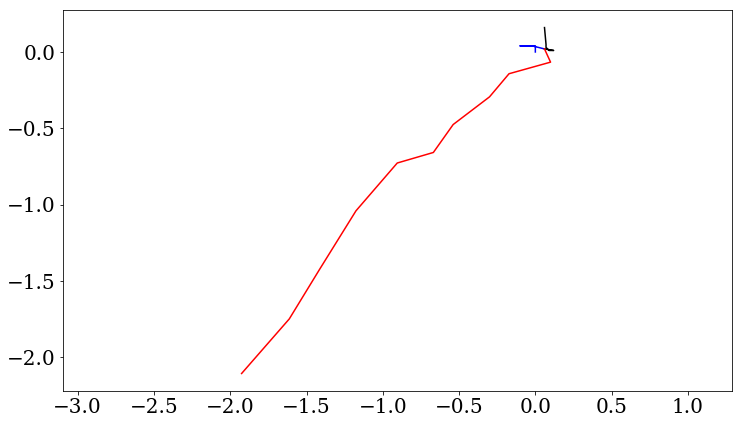

In [71]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_1.shape[0])

plt.plot(in_test_coord_1[:,ind,0],in_test_coord_1[:,ind,1],c='b')
plt.plot(gt_test_coord_1[:,ind,0],gt_test_coord_1[:,ind,1],c='k')
plt.plot(output_coord_1[:,ind,0],output_coord_1[:,ind,1],c='r')
plt.axis('equal')

In [72]:
output_coord_2=np.zeros([11,inputs_test_2.shape[2],2])
for j in range(11):
    for i in range(output_test_2.shape[1]):
        if j==0:
            output_coord_2[j,i,0:2] = in_test_coord_2[9,i,0:2]
        else:
            output_coord_2[j,i,0:2] = output_coord_2[j-1,i,0:2]+output_test_2[i,j-1,2:]*0.4
        

In [73]:
dist = np.zeros(inputs_test_2.shape[2])
for i in range(inputs_test_2.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_2[10,i,:]-output_coord_2[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 6.983


In [74]:
avr = np.zeros((gt_test_coord_2.shape[1],11))
for i in range(gt_test_coord_2.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_2[j,i,:]-output_coord_2[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 5.135


(-3.887532379587836, 0.22094548378989695, -0.6280428840000001, 13.188900564)

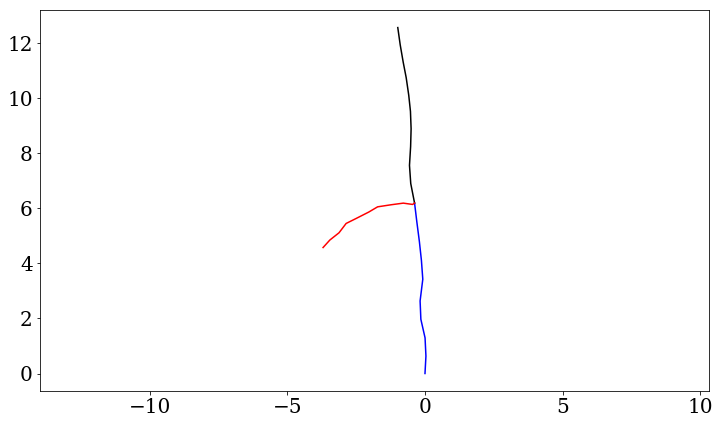

In [75]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_2.shape[0])

plt.plot(in_test_coord_2[:,ind,0],in_test_coord_2[:,ind,1],c='b')
plt.plot(gt_test_coord_2[:,ind,0],gt_test_coord_2[:,ind,1],c='k')
plt.plot(output_coord_2[:,ind,0],output_coord_2[:,ind,1],c='r')
plt.axis('equal')

In [76]:
output_coord_3=np.zeros([11,inputs_test_3.shape[2],2])
for j in range(11):
    for i in range(output_test_3.shape[1]):
        if j==0:
            output_coord_3[j,i,0:2] = in_test_coord_3[9,i,0:2]
        else:
            output_coord_3[j,i,0:2] = output_coord_3[j-1,i,0:2]+output_test_3[i,j-1,2:]*0.4
        

In [77]:
dist = np.zeros(output_coord_3.shape[1])
for i in range(gt_test_coord_3.shape[1]):
    dist[i] = np.sqrt(sum((gt_test_coord_3[10,i,:]-output_coord_3[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 4.962


In [78]:
avr = np.zeros((gt_test_coord_3.shape[1],11))
for i in range(gt_test_coord_3.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_3[j,i,:]-output_coord_3[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 3.829


(-0.8424555131793385,
 2.0481753767661077,
 -1.6949670941709367,
 3.3392856501986157)

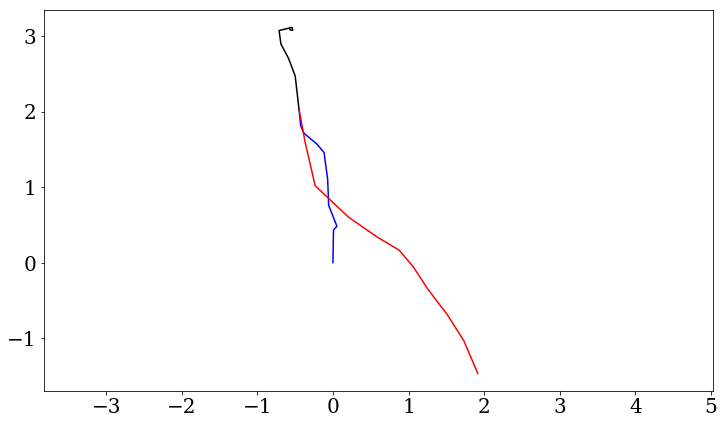

In [79]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_3.shape[0])

plt.plot(in_test_coord_3[:,ind,0],in_test_coord_3[:,ind,1],c='b')
plt.plot(gt_test_coord_3[:,ind,0],gt_test_coord_3[:,ind,1],c='k')
plt.plot(output_coord_3[:,ind,0],output_coord_3[:,ind,1],c='r')
plt.axis('equal')

In [80]:
torch.save(net.state_dict(), 'fullCNN_4.pt')

In [5]:
a=np.zeros([3,251,2])
a

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]])